In [1]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [2]:
ranking = spark.read.json("../data/all_ranking_20210731.json", multiLine=True)
ranking.cache()
ranking.show()

+--------+----+-------+--------+-----+--------------------+------------+----+--------------+--------------------+
|category|fame|  guild|     job|level|             mastery|        name|rank|specialization|           timestamp|
+--------+----+-------+--------+-----+--------------------+------------+----+--------------+--------------------+
|     all| 420|Project|magician|  200|              bishop|     Unlucky|   1|        cleric|2021-08-01T00:14:...|
|     all|2714|   Noir|   thief|  200|          night lord|        Babo|   2|      assassin|2021-08-01T00:14:...|
|     all| 784|   Noir|   thief|  200|          night lord|        Nude|   3|      assassin|2021-08-01T00:14:...|
|     all|1135|   Noir|magician|  200|              bishop|     JayChou|   4|        cleric|2021-08-01T00:14:...|
|     all| 263|Project|  bowman|  200|           bowmaster|    Zeretius|   5|        hunter|2021-08-01T00:14:...|
|     all| 143|Genesis|magician|  200|              bishop|  NeoGenesis|   6|        cle

In [3]:
ranking.createOrReplaceTempView("ranking")

In [6]:
spark.sql("""
select 
    name,
    count(*) as n
from ranking
group by 1
having n > 1
""").count()

131

In [8]:
spark.sql("""
with names as (
select 
    name,
    count(*) as n
from ranking
group by 1
having n > 1
)
select *
from ranking
right join names
using (name)
and 
""").show()

+---------+--------+----+-----+--------+-----+--------+------+--------------+--------------------+---+
|     name|category|fame|guild|     job|level| mastery|  rank|specialization|           timestamp|  n|
+---------+--------+----+-----+--------+-----+--------+------+--------------+--------------------+---+
| rawreoxd|     all|   0|     |beginner|    6|beginner|183390|           all|2021-08-01T20:40:...|  2|
| rawreoxd|     all|   0|     |beginner|    6|beginner|183391|           all|2021-08-01T20:40:...|  2|
|     ooop|     all|  22|     |magician|   41|  cleric| 51600|        cleric|2021-08-01T04:54:...|  2|
|     ooop|     all|  22|     |magician|   41|  cleric| 51601|        cleric|2021-08-01T04:54:...|  2|
|SweetSana|     all| 151|     |magician|   88|  priest| 19271|        cleric|2021-08-01T01:57:...|  2|
|SweetSana|     all| 151|     |magician|   88|  priest| 19282|        cleric|2021-08-02T01:46:...|  2|
| need2USE|     all|   0|     |beginner|    7|beginner|177285|           

In [70]:
deduped = spark.sql("""
with ranked as (
    select
        *,
        row_number() over (partition by name order by timestamp desc) as _rank
    from ranking
),
deduped as (
    select *
    from ranked
    where _rank = 1
)
select
    name,
    level,
    job,
    specialization,
    mastery,
    fame,
    guild,
    row_number() over (order by level desc, rank) as rank
from deduped
""")

deduped.show()

+------------+-----+--------+--------------+--------------------+----+-------+----+
|        name|level|     job|specialization|             mastery|fame|  guild|rank|
+------------+-----+--------+--------------+--------------------+----+-------+----+
|     Unlucky|  200|magician|        cleric|              bishop| 420|Project|   1|
|        Babo|  200|   thief|      assassin|          night lord|2714|   Noir|   2|
|        Nude|  200|   thief|      assassin|          night lord| 784|   Noir|   3|
|     JayChou|  200|magician|        cleric|              bishop|1135|   Noir|   4|
|    Zeretius|  200|  bowman|        hunter|           bowmaster| 263|Project|   5|
|  NeoGenesis|  200|magician|        cleric|              bishop| 143|Genesis|   6|
|      STRQNK|  200|   thief|      assassin|          night lord| 777|   Noir|   7|
|  BoldAsLove|  200|magician|           ice|archmage (ice/lig...| 200| Divide|   8|
|      CIeric|  200|magician|        cleric|              bishop|  88|   Noi

In [71]:
deduped.createOrReplaceTempView("ranking_deduped")

In [72]:
deduped.count()

201514

In [26]:
spark.sql("""
select
    mastery,
    count(distinct name) as n
from ranking_deduped
group by 1
order by n desc
""").show(n=50, truncate=False)

+------------------------+-----+
|mastery                 |n    |
+------------------------+-----+
|beginner                |45021|
|warrior                 |23155|
|magician                |22058|
|thief                   |16500|
|cleric                  |10145|
|bowman                  |9296 |
|assassin                |7775 |
|spearman                |7414 |
|pirate                  |7343 |
|wizard (ice/lightning)  |5843 |
|priest                  |4364 |
|bandit                  |4234 |
|bishop                  |4117 |
|hunter                  |3355 |
|fighter                 |2966 |
|wizard (fire/poison)    |2658 |
|hermit                  |2636 |
|brawler                 |2492 |
|gunslinger              |1693 |
|night lord              |1451 |
|archmage (ice/lightning)|1388 |
|page                    |1341 |
|crossbowman             |1189 |
|mage (ice/lightning)    |1162 |
|dark knight             |1149 |
|bowmaster               |1005 |
|dragon knight           |959  |
|chief ban

In [60]:
total = deduped.count()

In [61]:
spark.sql(f"""
select
    job,
    count(distinct name) as n,
    round(count(distinct name)/{total}*100, 1) as pct
from ranking_deduped
group by 1
order by n desc
""").show(n=50, truncate=False)

+--------+-----+----+
|job     |n    |pct |
+--------+-----+----+
|magician|53214|26.4|
|beginner|45021|22.3|
|warrior |39162|19.4|
|thief   |34375|17.1|
|bowman  |16185|8.0 |
|pirate  |13557|6.7 |
+--------+-----+----+



In [67]:
print("4th job mastery")

spark.sql("""
with nonfourth as (
    select distinct mastery
    from ranking_deduped
    where level < 120
),
counts as (
    select
        mastery,
        count(distinct name) as n
        -- round(mean(level), 1) as avg_level,
        -- round(stddev(level), 1) as std_level
    from ranking_deduped
    where mastery not in (select * from nonfourth)
    group by 1
    order by n desc
)
select
    mastery,
    n,
    round(n/(sum(n) over ())*100, 1) as pct
from counts
""").show(n=50, truncate=False)

4th job mastery
+------------------------+----+----+
|mastery                 |n   |pct |
+------------------------+----+----+
|bishop                  |4117|29.8|
|night lord              |1451|10.5|
|archmage (ice/lightning)|1388|10.1|
|dark knight             |1149|8.3 |
|bowmaster               |1005|7.3 |
|buccaneer               |944 |6.8 |
|archmage (fire/poison)  |928 |6.7 |
|hero                    |885 |6.4 |
|shadower                |822 |6.0 |
|paladin                 |414 |3.0 |
|corsair                 |351 |2.5 |
|marksman                |339 |2.5 |
+------------------------+----+----+



In [ ]:
print("jobs by characters that are at least 30")

spark.sql("""
select
    job,
    count(distinct name) as n
from ranking_deduped
where level >= 30
group by 1
order by n desc
""").show(n=50, truncate=False)

In [28]:
import matplotlib.pyplot as plt

df = spark.sql("""
select
    level,
    count(distinct name) as n
from ranking_deduped
group by 1
order by level
""").toPandas()

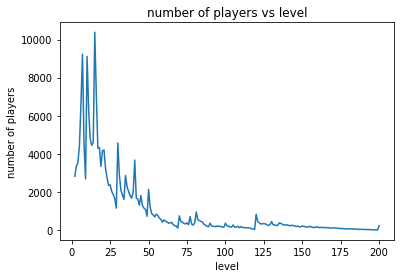

In [38]:
plt.plot(df.level, df.n)
plt.xlabel("level")
plt.ylabel("number of players")
plt.title("number of players vs level")
plt.show()

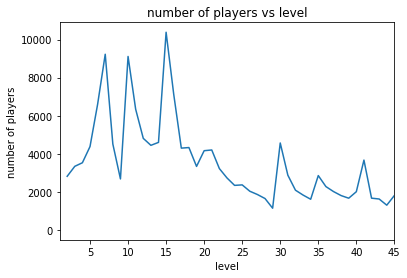

In [63]:
plt.plot(df.level, df.n)
plt.xlabel("level")
plt.ylabel("number of players")
plt.title("number of players vs level")
plt.xlim([1, 45])
plt.show()

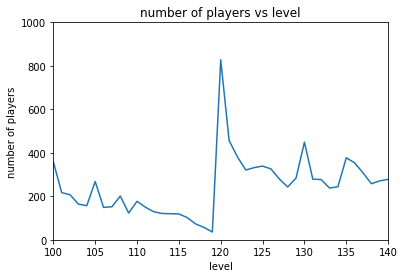

In [44]:
plt.plot(df.level, df.n)
plt.xlabel("level")
plt.ylabel("number of players")
plt.title("number of players vs level")
plt.xlim([100, 140])
plt.ylim([0, 1000])
plt.show()

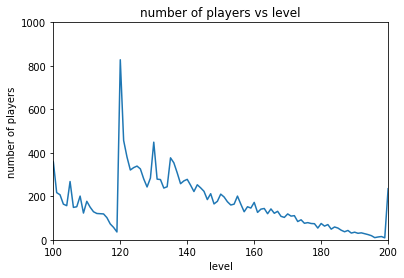

In [51]:
plt.plot(df.level, df.n)
plt.xlabel("level")
plt.ylabel("number of players")
plt.title("number of players vs level")
plt.xlim([100, 200])
plt.ylim([0, 1000])
plt.show()

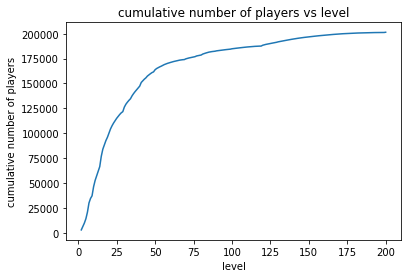

In [39]:
plt.plot(df.level, df.n.cumsum())
plt.xlabel("level")
plt.ylabel("cumulative number of players")
plt.title("cumulative number of players vs level")
plt.show()

In [73]:
deduped.toPandas().to_json("../data/all_ranking_20210731_deduped.json", orient="records")